In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F #
import pandas as pd
import matplotlib.pyplot as plt

## Model

In [34]:
class NN(nn.Module):
    def __init__(self, input_size,num_output):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,num_output)

    def forward(self,x):
        # print(x)
        x = torch.tanh(self.fc1(x))
        # print(x)
        x = torch.tanh(self.fc2(x))
        # print(x)
        x = self.fc3(x)
        return x

model = NN(8,3)

## Train and Test divsion

In [35]:
df = pd.read_csv('dataset.csv')
train_x = df[0:800][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()
test_x = df[800:999][['ar-0','ar-1','ar-2','ar-3','pr-0','pr-1','pr-2','pr-3']].to_numpy()

train_y = df[0:800][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()
test_y = df[800:999][['n-class-0-latency','n-class-1-bw','n-class-2-bw']].to_numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 800 # 28x28 = 784, size of MNIST images (grayscale)
num_output = 3


## Loss parameter

In [36]:
learning_rate = 0.0001
num_epochs = 100

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
loss_func = nn.MSELoss()


## Training

In [37]:
for epoch in range(num_epochs):
    where_are_NaNs = np.isnan(train_y)
    train_y[where_are_NaNs] = 0
    prediction = model(torch.from_numpy(train_x).float())

    loss = loss_func(prediction.float(), torch.from_numpy(train_y).float())
    # print(loss)
    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients
    train_loss.append(loss.data.numpy())

## Ploting training loss 

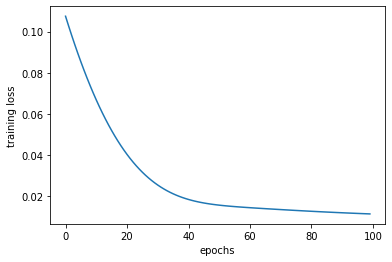

In [38]:
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.plot(train_loss)
plt.show()

## Prediction loss

In [39]:
predict_test_y = model(torch.from_numpy(test_x).float())

test_loss = loss_func(predict_test_y.float(),torch.from_numpy(test_y).float())


prediction_un = predict_test_y.clone().detach().numpy()



## Unormalized predictions

In [40]:
prediction_un[:,0] = np.reciprocal(prediction_un[:,0])/0.320
prediction_un[:,1] = 13600*prediction_un[:,1]
prediction_un[:,2] = 13600*prediction_un[:,2]


test_y_un = np.copy(test_y)

test_y_un[:,0] = np.reciprocal(test_y[:,0])/0.320
test_y_un[:,1] = 13600*test_y[:,1]
test_y_un[:,2] = 13600*test_y[:,2]

x = np.concatenate((prediction_un,test_y_un),axis=1)

## Ploting and saving predictions

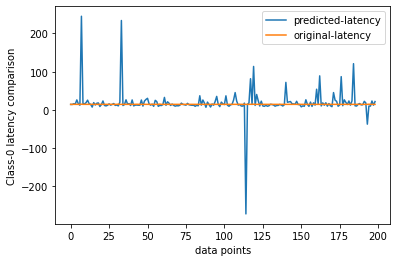

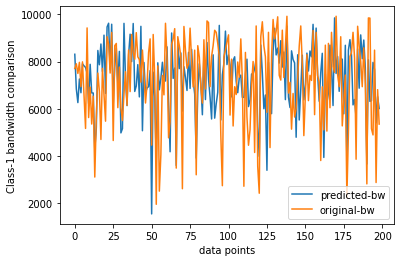

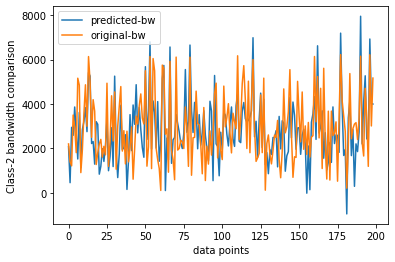

In [42]:
plt.plot(x[:,0],label='predicted-latency')
plt.plot(x[:,3],label='original-latency')
plt.xlabel('data points')
plt.ylabel('Class-0 latency comparison')
plt.legend()
plt.show()


plt.plot(x[:,1],label='predicted-bw')
plt.plot(x[:,4],label='original-bw')
plt.xlabel('data points')
plt.ylabel('Class-1 bandwidth comparison')
plt.legend()
plt.show()


plt.plot(x[:,2],label='predicted-bw')
plt.plot(x[:,5],label='original-bw')
plt.xlabel('data points')
plt.ylabel('Class-2 bandwidth comparison')
plt.legend()
plt.show()

np.savetxt('prediction_comparison.csv', x, delimiter =', ', header="p-class-0-lat,p-class-1-bw,p-class-2-bw,o-class-0-lat,o-class-1-bw,o-class-2-bw")


## Prediction

In [10]:
model.requires_grad_(requires_grad=False)
x = torch.nn.Parameter(torch.tensor([16.0,15.0,22.0,10.0,100.0,82.0,65.0,41.0]), requires_grad=True)
optim = torch.optim.SGD([x], lr=0.5)
mse = torch.nn.MSELoss()
y = torch.ones(3)  # the desired network response
y[2] = 10
num_steps = 500  # how many optim steps to take
print('original x : ',x)
for _ in range(num_steps):
   # pred_opt = model()
   loss = mse(model(x), y)
   loss.backward()
   optim.step()
   optim.zero_grad()

print('x', x)

original x :  Parameter containing:
tensor([ 16.,  15.,  22.,  10., 100.,  82.,  65.,  41.], requires_grad=True)
x Parameter containing:
tensor([ 18.8180,  15.7593,  23.7978,  11.6667, 100.4861,  78.7854,  67.0399,
         40.2046], requires_grad=True)
